# 機器學習百日馬拉松期中考 
### -Enron Fraud Dataset 安隆公司詐欺案資料集  
安隆公司曾是一間能源公司，2001 年破產前是世界上最大的電力、天然氣及電信公司之一。擁有上千億資產的公司於 2002 年竟然在短短幾周內宣告破產，才揭露其財報在多年以來均是造假的醜聞。在本資料集中你將會扮演偵探的角色，透過高層經理人內部的 mail 來往的情報以及薪資、股票等財務特徵，訓練出一個機器學習模型來幫忙你找到可疑的詐欺犯罪者是誰! 我們已經先幫你找到幾位犯罪者 (Person-of-Interest, poi) 與清白的員工，請利用這些訓練資料來訓練屬於自己的詐欺犯機器學習模型吧!

In [1]:
# 載入需要的套件
import pandas as pd
import numpy as np
import copy, time

from IPython.display import display

from sklearn import datasets, metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture as GMM

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(20))

In [40]:
# 資料轉入
data_path = '../03 data/3rd-ml100marathon-midterm/'

df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')

train_Y = df_train['poi']
ids = df_test['name']

df_train = df_train.drop(['poi', 'name'] , axis=1)
df_test = df_test.drop(['name'] , axis=1)
df = pd.concat([df_train,df_test])

# #特殊值處理
# df_train = df_train.drop(['poi'] , axis=1)
# df = pd.concat([df_train,df_test])
# df['IsTotal'] = df['name'].map(lambda s: 1 if s=='TOTAL' else 0)


df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [41]:
# 補空值
for col in ['deferral_payments', 
            'loan_advances', 
            'other',
            'salary', 
            'bonus', 
            'long_term_incentive',
            'deferred_income', 
            'expenses', 
            'director_fees']:
    df[col].fillna(0, inplace=True)

# total_payments = Salary,Bonus,Long Term  Incentive,Deferred Deferral Income, Deferral Payments , Loan Advances ,Other, Expenses ,  Director Fees
df['total_payments']=df['deferral_payments']+df['loan_advances']+df['other']+df['salary']+df['bonus']+df['long_term_incentive']+df['deferred_income']+df['expenses']+df['director_fees']

for col in ['exercised_stock_options', 
            'restricted_stock', 
            'restricted_stock_deferred']:
    df[col].fillna(0, inplace=True)
    
# total_stock_value = exercised_stock_options  +restricted_stock + restricted_stock_deferred    
df['total_stock_value']=df['exercised_stock_options']+df['restricted_stock']+df['restricted_stock_deferred']

#Messages Times
for col in ['to_messages', 
            'shared_receipt_with_poi', 
            'from_this_person_to_poi', 
            'from_poi_to_this_person',
            'from_messages']:
    df[col].fillna(0, inplace=True)
    
#object fill None
for col in ['email_address']:
    df[col].fillna('none', inplace=True)

df['HasEmail'] = df['email_address'].map(lambda s: 0 if s=='none' else 1)

#檢查空值
na_check(df)

,Missing Ratio


In [30]:
#數值欄位處理
col_numeric = df.select_dtypes(include=['int64', 'float64']).columns
# df_numeric = df[df['name']!='TOTAL'].select_dtypes(include=['int64', 'float64'])
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# print(df_numeric.shape)
print(df_numeric.nunique())
print(df_numeric.describe())


bonus                         42
deferral_payments             40
deferred_income               45
director_fees                 18
exercised_stock_options      102
expenses                      95
from_messages                 65
from_poi_to_this_person       57
from_this_person_to_poi       41
loan_advances                  5
long_term_incentive           53
other                         93
restricted_stock              98
restricted_stock_deferred     19
salary                        95
shared_receipt_with_poi       84
to_messages                   87
total_payments               126
total_stock_value            126
HasEmail                       2
dtype: int64
              bonus  deferral_payments  deferred_income  director_fees  \
count  1.460000e+02       1.460000e+02     1.460000e+02   1.460000e+02   
mean   1.333474e+06       4.387965e+05    -3.827622e+05   1.942249e+04   
std    8.094029e+06       2.741325e+06     2.378250e+06   1.190543e+05   
min    0.000000e+00      -1.025

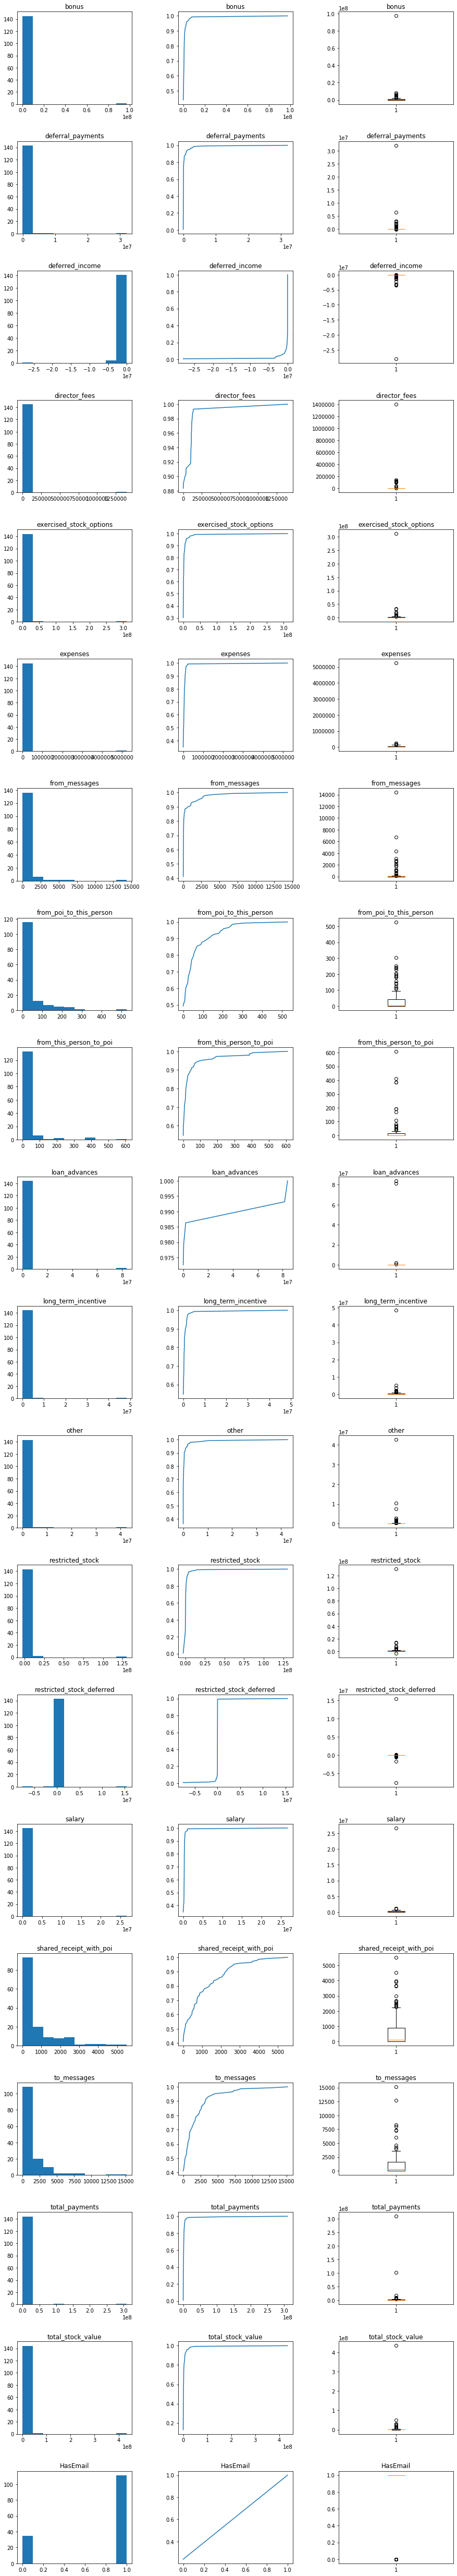

In [31]:
ncols = len(df_numeric.columns)
nrows = df_numeric.shape[0]

fig, axs = plt.subplots(ncols, 3, figsize=(15,90))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

iCols=-1

#各欄位圖型觀查分配狀況
for col in df_numeric.columns:
    #欄位計教
    iCols=iCols+1
    
    # 繪製 直方圖
    axs[iCols, 0].hist(x=df_numeric[col])
    axs[iCols, 0].set_title(col)
    
    # 繪製 Empirical Cumulative Density Plot (ECDF)
    cdf = df_numeric[col].value_counts().sort_index().cumsum()
    axs[iCols, 1].plot(list(cdf.index), cdf/cdf.max())
    axs[iCols, 1].set_title(col)
    
    # 繪製 盒狀圖
    axs[iCols, 2].boxplot(x=df_numeric[col])
    axs[iCols, 2].set_title(col)

In [33]:
for col in ['deferral_payments', 
            'deferred_income',
            'from_messages',
             'other', 
            'restricted_stock_deferred', 
            'total_payments',
            'from_messages']:
    df[col] = df[col].map(lambda i: np.log(i) if i > 0 else 0)
    


In [42]:
#文字欄位處理
col_object = df.select_dtypes(include=['int64', 'float64']).columns
df_object = df.select_dtypes(include=['object'])

df = df.drop(['email_address'] , axis=1)
df_object.nunique()

email_address    112
dtype: int64

In [43]:
#標準化處理
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = LabelEncoder().fit_transform(list(df[c].values))
    
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape(-1, 1))

# # 將資料最大最小化
# df = MinMaxScaler().fit_transform(df)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]

test_X = df[train_num:]

In [50]:
#資料變數
X=train_X

# 建立模型
lr = LogisticRegression(tol=0.001, fit_intercept=True)


param_grid = dict(C=np.linspace(.0001, 1000, 200),
                  penalty=['l1', 'l2'])

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(lr, param_grid, scoring="accuracy", n_jobs=-1, verbose=3, cv=5)


# 開始搜尋最佳參數
grid_result = grid_search.fit(X, train_Y)
svc=grid_search.best_estimator_.fit(X, train_Y)

#分數評估
print ('best'), grid_search.best_estimator_.score(X, train_Y)
scores = cross_val_score(svc, X, train_Y,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    2.4s


best
0.8940711462450592 0.8260869565217391
[0.91304348 0.82608696 0.91304348 0.90909091 0.90909091]


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    9.2s finished


In [51]:
# 計算提交結果
X_t = test_X
y_pred=grid_search.best_estimator_.predict_proba(X_t)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': y_pred})
sub.to_csv('Day_051_HW_lr.csv', index=False)

In [44]:
#資料變數
X=train_X

# 建立模型
clf = RandomForestClassifier()

# 設定要訓練的超參數組合
param_grid = dict(n_estimators=[100, 300, 500, 1000],
                  min_samples_leaf=[1, 3, 5],
                  max_depth=[1, 3, 5, 7],
                  criterion=['entropy'])

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(clf, param_grid, scoring="accuracy", n_jobs=-1, verbose=3, cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(X, train_Y)
svc=grid_search.best_estimator_.fit(X, train_Y)

#分數評估
print ('best'), grid_search.best_estimator_.score(X, train_Y)
scores = cross_val_score(svc, X, train_Y,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   39.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
feats = pd.Series(data=clf_bestparam.feature_importances_, index=train_X.columns)
feats = feats.sort_values(ascending=False)
print('特徵重要性\n',feats)

特徵重要性
 other                        0.137131
expenses                     0.115694
exercised_stock_options      0.094503
total_stock_value            0.094497
salary                       0.070773
restricted_stock             0.069848
bonus                        0.068010
total_payments               0.059365
shared_receipt_with_poi      0.052318
from_messages                0.045558
long_term_incentive          0.036618
from_this_person_to_poi      0.036187
deferred_income              0.035281
from_poi_to_this_person      0.034424
to_messages                  0.030754
HasEmail                     0.008351
deferral_payments            0.008047
loan_advances                0.001838
restricted_stock_deferred    0.000559
director_fees                0.000242
dtype: float64


In [46]:
# 計算提交結果
X_t = test_X
y_pred=grid_search.best_estimator_.predict_proba(X_t)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': y_pred})
sub.to_csv('Day_051_HW_rf.csv', index=False)

In [ ]:
#資料變數
X=train_X

# 建立模型
gdbt = GradientBoostingClassifier()

# 設定要訓練的超參數組合
param_grid = dict(n_estimators=[100, 300, 500, 1000],
                  max_depth=[1, 3, 5, 7])

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(gdbt, param_grid, scoring="accuracy", n_jobs=-1, verbose=3, cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(X, train_Y)
svc=grid_search.best_estimator_.fit(X, train_Y)

#分數評估
print ('best'), grid_search.best_estimator_.score(X, train_Y)
scores = cross_val_score(svc, X, train_Y,cv=5,scoring='accuracy')
print(scores.mean(),scores.min())
print(scores)

In [ ]:
# 計算提交結果
X_t = test_X
y_pred=grid_search.best_estimator_.predict_proba(X_t)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': y_pred})
sub.to_csv('Day_051_HW_gdbt.csv', index=False)

In [ ]:
feats = pd.Series(data=rf.feature_importances_, index=train_X.columns)
feats = feats.sort_values(ascending=False)
print('特徵重要性\n',feats)